
# 作業: 
    
    (1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化
    
    (2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:

'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 

batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes) 

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [7]:
# 輸出模型摘要資訊
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [8]:
'''
 SGD(隨機梯度下降) - Arguments
lr: float >= 0. Learning rate.
momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
decay: float >= 0. Learning rate decay over each update.
nesterov: boolean. Whether to apply Nesterov momentum.
'''
sgd = optimizers.SGD(lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True)

'''
RMSprop- Arguments
lr: float >= 0. Learning rate.
rho: float >= 0.
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
decay: float >= 0. Learning rate decay over each update.
'''
rmsprop = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [9]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [15]:
def hw_fit(model, data_augmentation=False):
    if not data_augmentation:
        print('Not using data augmentation.')
        history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
    else:
        print('Using real-time data augmentation.')
        print('')
        
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)
        
        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)
        history=model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_test, y_test),
                          shuffle=True)   
    return history

In [16]:
def show(history):
    import matplotlib.pyplot as plt
    %matplotlib inline
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valiidation'], loc='upper left')
    plt.show()

Using real-time data augmentation.

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 17s 332us/step - loss: 0.3263 - acc: 0.8999 - val_loss: 0.3252 - val_acc: 0.9000
Epoch 2/20
50000/50000 [==============================] - 12s 237us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 3/20
50000/50000 [==============================] - 12s 239us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3252 - val_acc: 0.9000
Epoch 4/20
50000/50000 [==============================] - 12s 238us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3253 - val_acc: 0.9000
Epoch 5/20
50000/50000 [==============================] - 12s 238us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 6/20
50000/50000 [==============================] - 12s 243us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3252 - val_acc: 0.9000
Epoch 7/20
50000/50000 [========

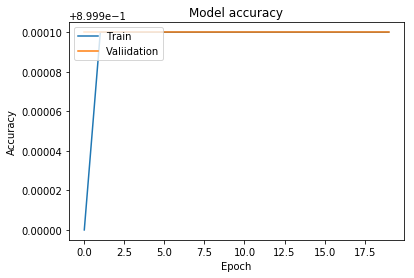

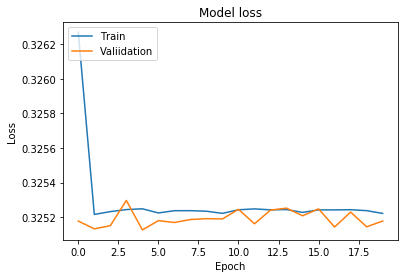

In [18]:
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = hw_fit(model, data_augmentation)
show(history)

In [ ]:
'''
train.shape = (50000, 32, 32, 3)
batch_size, epoches = 32, 20
'''

In [21]:
50000/32

1562.5

In [20]:
50000/256

195.3125

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 113us/step - loss: 0.3253 - acc: 0.9000 - val_loss: 0.3252 - val_acc: 0.9000
Epoch 2/10
50000/50000 [==============================] - 5s 97us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 3/10
50000/50000 [==============================] - 5s 96us/step - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3252 - val_acc: 0.9000
Epoch 4/10
50000/50000 [==============================] - 5s 97us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 5/10
50000/50000 [==============================] - 5s 94us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 6/10
50000/50000 [==============================] - 5s 97us/step - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 7/10
50000/50000 [==============================] - 5s 98us/step - loss: 0.3252 - acc

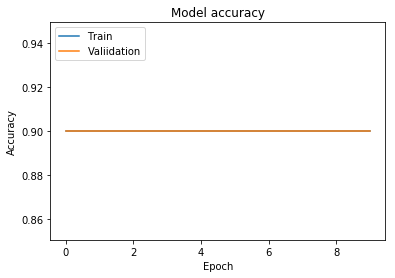

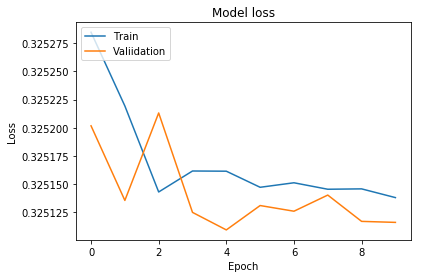

In [22]:
batch_size, epochs = 256, 10
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = hw_fit(model, data_augmentation)
show(history)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 224us/step - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 2/10
50000/50000 [==============================] - 11s 210us/step - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 3/10
50000/50000 [==============================] - 11s 212us/step - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 4/10
50000/50000 [==============================] - 10s 206us/step - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 5/10
50000/50000 [==============================] - 11s 215us/step - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 6/10
50000/50000 [==============================] - 11s 222us/step - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 7/10
50000/50000 [==============================] - 11s 218us/step - loss:

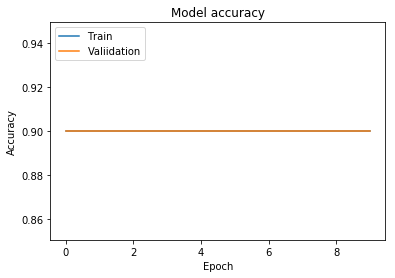

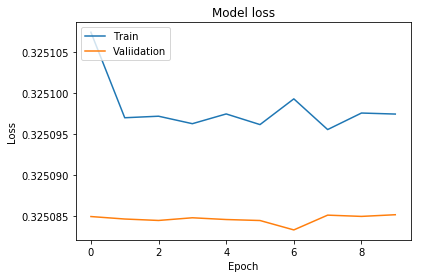

In [23]:
batch_size, epoches = 32, 20
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = hw_fit(model, data_augmentation)
show(history)

In [ ]:
batch_size, epoches = 32, 20
model.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = hw_fit(model, data_augmentation)
show(history)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 242us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3253 - val_acc: 0.9000
Epoch 2/10
50000/50000 [==============================] - 11s 226us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3253 - val_acc: 0.9000
Epoch 3/10
50000/50000 [==============================] - 12s 232us/step - loss: 0.3253 - acc: 0.9000 - val_loss: 0.3253 - val_acc: 0.9000
Epoch 4/10
50000/50000 [==============================] - 11s 226us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3253 - val_acc: 0.9000
Epoch 5/10
50000/50000 [==============================] - 11s 225us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3252 - val_acc: 0.9000
Epoch 6/10
50000/50000 [==============================] - 11s 226us/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3253 - val_acc: 0.9000
Epoch 7/10
49920/50000 [============================>.] - ETA: 0s - loss: 0.3252

In [ ]:
def train(opt, batch_size = 32, epochs=1000):
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    
    #training
    history = model.fit(X_train,Y_train,batch_size = batch_size, epochs=epochs, 
                        shuffle=True,verbose=2,validation_split=0.3 )
    
    #test
    print ( " test set " )
    scores batch_size, epoches = 32, 20
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = hw_fit(model, data_augmentation)
show(history)= model.evaluate(X_test,Y_test,batch_size=batch_size,verbose= 0)
    print ( "" )
    print ( " The test loss is %f ", scores)
    result = model.predict(X_test,batch_size=batch_size,verbose= 0)
    
    result_max = numpy.argmax(result, axis = 1 )
    test_max = numpy.argmax(Y_test, axis = 1 )
    result_bool = numpy.equal(result_max, test_max)
    true_num = numpy.sum(result_bool)
    print ( "" )
    print ( " The accuracy of the model is %f " % (true_num/len(result_bool)))
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
for b in [32]:
    for ep in [20,10]:
        train(adam, b, ep)

In [ ]:
train(sgd, 210, 200)

In [ ]:
train(rmsprop, 210, 200)